In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
# from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm

### Задача 1. CUPED (2.5 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [6]:
control_before = stats.expon(scale=1000).rvs(1000)

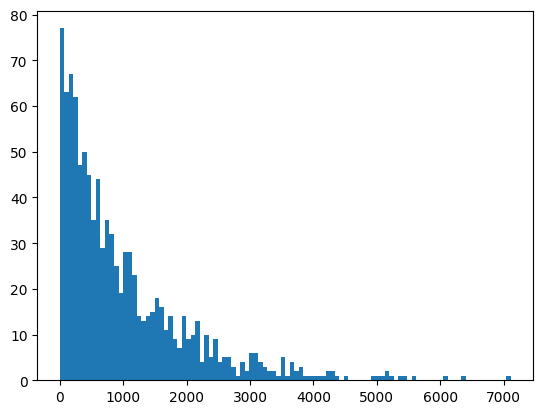

In [7]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [8]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

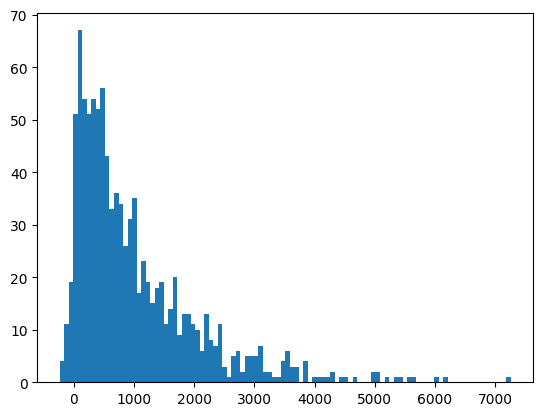

In [9]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [10]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 941.47102065, 1070.82819665])

In [11]:
bad_cnt = 0

N = 10000
for i in range(N):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

Стат значимая разница есть в 4.83% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [12]:
bad_cnt = 0

N = 10000
for i in range(N):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    theta = (np.cov(control_before, control) / np.var(control_before))[1, 0]
    control_cuped = control - theta * control_before + theta * control_before.mean()
    mean = control_cuped.mean()
    std = control_cuped.std() / np.sqrt(len(control_cuped))
                                        
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

Стат значимая разница есть в  84.45% случаев;


In [13]:
std

3.1346765137369905

Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [14]:
def calc_theta(a, b, a_before, b_before):
    y = np.hstack([a, b])
    y_before = np.hstack([a_before, b_before])
    return np.cov(y_before, y)[0, 1] / y_before.var()


bad_cnt = 0
ttest_cnt = 0

N = 10000
for i in range(N):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(samples_in_ab // 2)
    control_after_b = control_before_b + stats.norm(loc=0, scale=100).rvs(samples_in_ab // 2)

    theta_2 = calc_theta(control_after_a, control_after_b, control_before_a, control_before_b)

    control_cup_a = control_after_a - theta_2 * (control_before_a - control_before_full.mean())
    control_cup_b = control_after_b - theta_2 * (control_before_b - control_before_full.mean())

    # control_cup_a = control_after_a - theta_2 * (control_before_a)
    # control_cup_b = control_after_b - theta_2 * (control_before_b)

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1

    ttest_cnt += int(stats.ttest_ind(control_cup_a, control_cup_b).pvalue < 0.05)

print(f"Стат значимая разница есть в  {(round(bad_cnt / N, 4) * 100):.4f}% случаев;")

Стат значимая разница есть в  4.9100% случаев;


In [15]:
ttest_cnt / N * 100

5.04

Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:

В первом случае применения CUPED фактически сделали регрессию переменной самой на себя, что в целом пожалуй не очень корректно, тк $Var(Y_{cuped}) = Var(Y) * (1 - \rho) \approx 0 $ и ну как бы да (не ноль за счет наличия некоторого независимого нормального $\epsilon$). С околонулевой дисперсией любое отклонения от нуля будет казаться нам стат значимым 

А далее мы считаем $\theta$ на всей доступной выборке (на двух группах, с эффектом или без). То есть уже немного лучше, дисперсия уменьшается в подвыборках именно за счет корреляции приближенного исходного распределения и зашумленных значений. И соответственно мы "убираем" информацию об исходном распределении, и, в сущности, сравниваем два нормальных шума с одинаковыми параметрами. И логично получаем стат значимую разницу на уровне ошибки первого рода. 


Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [16]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
for i in range(N):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    mean_3 = control_before_full.mean()

    control_after_a = control_before_a + stats.norm(loc=0, scale=100).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=10, scale=100).rvs(
        samples_in_ab // 2
    )

    theta_3 = calc_theta(control_after_a, control_after_b, control_before_a, control_before_b)
    
    control_cup_a = control_after_a - theta_3 * (control_before_a - mean_3)
    control_cup_b = control_after_b - theta_3 * (control_before_b - mean_3)

    if stats.kstest(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt += 1

    if stats.kstest(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt_cuped += 1

print(
    f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100:.2f}% случаев; при использовании CUPED -- в {(round(bad_cnt_cuped / N, 4) * 100):.2f}% случаев"
)

Стат значимая разница есть в  6.10% случаев; при использовании CUPED -- в 47.10% случаев


### Задача 2. Методы снижения дисперсии (2.5 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: 
- `None` - пользователь не участвует в АБ тесте, 
- `*_before_i` - соответствующая группа до начала теста, 
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение. 

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Задание
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED. 

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [206]:
from scipy.stats import t

def ttest(a, b, alpha = 0.05, H_a='two-sided', print_res=False):
    """проверяет H_0: mu_a - mu_b = 0"""
    n1, n2 = a.shape[0], b.shape[0]
    s1, s2 = a.std(), b.std()
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    d_f = s**4 / ((s1**2/n1)**2/(n1 - 1) + (s2**2/n2)**2/(n2 - 1))
    T_obs = (a.mean() - b.mean()) / s
    if H_a == 'two-sided': 
        l, r = t(df=d_f).ppf([0.025, 0.975])
        p_value = min(2 * t.cdf(T_obs, d_f), 2 * (1 - t.cdf(T_obs, d_f)))
        if print_res == True:
            # print(f'T_observed: {round(T_obs, 3)}, s_observed: {round(s, 3)}')
            if T_obs < l or T_obs > r:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)
     #H_a: mu_a - mu_b > 0
    elif H_a == 'right':
        p_value = 1 - t(df=d_f).cdf(T_obs)
        if print_res:
            if p_value > alpha:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)
    #H_a: mu_a - mu_b < 0
    elif H_a == 'left':
        p_value = t(df=d_f).cdf(T_obs)
        if print_res:
            if p_value > alpha:
                print(f'regect H_0, p-value = {p_value:.3f}')
            else: 
                print(f'accept H_0, p-value = {p_value:.3f}')
        return p_value, (p_value > alpha)

In [20]:
data = pd.read_csv("data_ab.csv")

Размеры групп для тестирования одинаковые, поэтому можем привести данные в чуть более удобный вид

In [49]:
group_list = ['control_before','treatment_before', 'control_after_1',
               'treatment_after_1', 'control_after_2', 'treatment_after_2',
               'control_after_3', 'treatment_after_3', 'control_after_4',
               'treatment_after_4', 'control_after_5', 'treatment_after_5']

def transform_data(data, age_list = ['young', 'adult', 'old'], group_list=group_list):
    for a in age_list:
        df = pd.DataFrame()
        df.loc[:, 'age'] = (
            data.loc[(data.age == a) & (data.group == 'treatment_after_1')]
            .age.reset_index(drop=True)
        )
        for g in group_list:
            df.loc[:, g] = data.loc[(data.age == a) & (data.group == g)].reset_index(drop=True).metric
        yield df

In [50]:
df = pd.concat(transform_data(data), axis=0)

df.head(2)

,age,control_before,treatment_before,control_after_1,treatment_after_1,control_after_2,treatment_after_2,control_after_3,treatment_after_3,control_after_4,treatment_after_4,control_after_5,treatment_after_5
0,young,8496.554679,11309.036916,8741.374306,11001.898483,9113.675629,10963.358305,8953.734508,10951.917020,9030.087523,11044.747851,9109.208016,11086.638630
1,young,11891.862586,9229.445011,11818.071476,9312.880516,12178.351619,9656.437561,12299.423731,9722.345791,12407.289137,9673.505484,12228.813543,10073.284614


In [156]:
ttest(df.control_before, df.treatment_before)

(0.9642001147497369, True)

#### Post-strat

In [143]:
# считаем веса на всех уникальных юзерах
weights = (
    data[data.group.isin(['treatment_before', 'control_before']) | data.group.isnull()]
    .age.value_counts(normalize=True, sort=False)
)

In [151]:
def calculate_weighted_stats(df: pd.DataFrame, weights: pd.Series, cat_column='age'):
    """
    args:
        df (pd.DataFrame): 
            cat_column (str) - category for aggregation
            <amount> (float) - value to calculate mean and std
        weights (pd.Series):
            weights.index (str) - category
            weights.values (float) - weight of a category
        cat_column (str): name of a category
    return:
        (mean, std)
    """
    grouped = df.groupby(cat_column).agg(['mean', 'std'])
    grouped.columns = ['mean_est', 'std_est']
    grouped.loc[:, 'weight'] = grouped.index.map(weights)

    return (
        (grouped.mean_est * grouped.weight).sum(),
        (grouped.std_est * grouped.weight).sum(),
    )

In [155]:
calculate_weighted_stats(df.iloc[:, :2], weights)

(11533.27212545056, 1268.8579675172152)

In [202]:
def ttest_strat(a: pd.DataFrame, b: pd.DataFrame, weights: pd.Series,
                cat_column: str ='age', alpha = 0.05, print_res=False,):
    """
    args:
        a (pd.DataFrame): 
            cat_column (str) - category for aggregation
            <amount> (float) - value to test avg
        b (pd.DataFrame) - same as a
        
        weights (pd.Series):
            weights.index (str) - category
            weights.values (float) - weight of a category
        cat_column (str): name of a category
    return:
        (p-value, res)
    """
    n1 = len(a)
    n2 = len(b)

    a_mean, s1 = calculate_weighted_stats(a, weights, cat_column)
    b_mean, s2 = calculate_weighted_stats(b, weights, cat_column)

    # реализую только двусторонний
    s = np.sqrt(s1**2 / n1 + s2**2 / n2)
    d_f = s**4 / ((s1**2/n1)**2/(n1 - 1) + (s2**2/n2)**2/(n2 - 1))
    T_obs = (a_mean - b_mean) / s
    l, r = t(df=d_f).ppf([alpha / 2, (1 - alpha) / 2])
    p_value = min(2 * t.cdf(T_obs, d_f), 2 * (1 - t.cdf(T_obs, d_f)))

    decision = 'regect H_0' if T_obs < l or T_obs > r else 'accept H_0'
    if print_res == True:
        print(f'T_obs: {round(T_obs, 3):.3f}, s_obs: {round(s, 3):.3f}, p-value {round(p_value, 3):.3f}, {decision}')
    return round(p_value, 4), (p_value > alpha)

#### CUPED

выбираем в качестве ковариаты прошлые значения метрики по юзерам из обеих групп.~~выбираем как и положено из множества доступных вариантов~~

In [209]:
def ttest_cuped(a: np.array, b: np.array, a_before: np.array, b_before: np.array,
                mu: float, alpha = 0.05, print_res=False):
    """
    a - for control group
    b - for treatment
    mu - mean by full available data 
    """
    n1, n2 = len(a), len(b)
    theta = calc_theta(a, b, a_before, b_before)
    # print(theta)
    a_cuped = a - theta * a_before + theta * mu
    b_cuped = b - theta * b_before + theta * mu

    res = ttest(a_cuped, b_cuped, alpha=alpha)
    return print(f'pvalue={round(res[0], 3)},', 'H0 rejected' if res[0] else 'H0 accepted')

#### Проверяем

In [208]:
for i in range(1, 6):

    ttest(
        df[f'control_after_{i}'].to_numpy(),
        df[f'treatment_after_{i}'].to_numpy(),
        print_res=True
    )

accept H_0, p-value = 0.692
accept H_0, p-value = 0.403
accept H_0, p-value = 0.234
accept H_0, p-value = 0.121
accept H_0, p-value = 0.054


In [177]:
MU = data[data.group.isin(['treatment_before', 'control_before']) | data.group.isnull()].metric.mean()

In [214]:
for i in range(1, 6):

    ttest_strat(
        df[['age', f'control_after_{i}']],
        df[['age', f'treatment_after_{i}']],
        weights=weights,
        cat_column='age',
        print_res=True
    )

T_obs: -1.163, s_obs: 27.018, p-value 0.245, accept H_0
T_obs: -2.307, s_obs: 27.478, p-value 0.021, regect H_0
T_obs: -3.191, s_obs: 27.895, p-value 0.001, regect H_0
T_obs: -4.053, s_obs: 28.368, p-value 0.000, regect H_0
T_obs: -4.982, s_obs: 28.759, p-value 0.000, regect H_0


In [210]:
for i in range(1, 6):

    ttest_cuped(
        df[f'control_after_{i}'].to_numpy(),
        df[f'treatment_after_{i}'].to_numpy(),
        df['control_before'].to_numpy(),
        df['treatment_before'].to_numpy(),
        MU, 
        print_res=True
    )

pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected
pvalue=0.0, H0 rejected


1. При обычном тестировании мы бы не получили на первых двух итерациях результатов в принципе, а далее наши выводы будут довольно чувствительны к выбору уровня значимости и альтернативной гипотезы
2. Стратификация уже на второй итерации дает стат. значимый результат 
3. А CUPED совсем жестко уменьшает дисперсию, получаем стат значимые результаты для любого разумного уровня значимости

Так что в нашем небольшом соревновании победил cuped, но что и несильно удивительно, учитывая уровень связи "выбранной" ковариаты

### Задача 3. Линеаризация + CUPED (2 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.

### Задача 4. Последовательное тестирование (3 балла)

Сгенерируйте две контрольные выборки и одну тестовую (с эффектом). Проведите последовательные АА-тесты и АБ-тесты по следующей схеме:

1. Попробуйте использовать t-test. Начните с 1 наблюдения в группах и последовательно добавлять по одному в каждую. Проследите, как меняется О1Р, О2Р.

2. Самостоятельно реализуйте **SPRT-тест Вальда** и проделайте ту же процедуру с ним. Что теперь происходит с О1Р и О2Р? Почему?

### Задача 5. Бонус от лектора (5 баллов)

_3 балла за выполнение __всех__ пунктов 1-5. +2 балла за пункт 6, при условии, что пункты 1-5 выполнены._

1. Реализуйте mSPRT, предполагая, что функция правдободобия имеет нормальное распределение 
2. Выведите теоретический вид статистики $\Lambda_n$ для нормального распределения 
3. Постройте распределение времени остановки для mSPRT и распределение p-value на А/А тесте 
4. Сделайте то же самое, но для синтетического А/В (добавьте искуственно эффект). Опишите, что поменялось 
5. Сравните mSPRT с классическим t-test
6. Замените расчет интеграла  $\Lambda_n$ на численное приближение расчета. Сравните результаты по пункту 3 и 4